## Load Data and Prepare Features
Load train and validation splits, extract features and targets, and handle missing values using median.


In [1]:
# Prepare features and targets for training
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd


MAX_DAY_TARGET = 60  # feel free to try 30, 45, 60, etc.

df_train = pd.read_csv("data/splits/train.csv")
df_val = pd.read_csv("data/splits/val.csv")

# Prepare features (X): day_of_month, is_weekend, is_public_holiday, days_from_summer_start
feature_cols = [
    "day_of_month",
    "is_weekend",
    "is_public_holiday",
    "days_from_summer_start",
]
X_train = df_train[feature_cols].values
X_val = df_val[feature_cols].values

# Prepare targets (y): up to MAX_DAY_TARGET days-to-departure columns
all_target_cols = [col for col in df_train.columns if "days to departure" in col]

#helps find which N days to departure we are at
def extract_day(col_name: str) -> int:
    # column format: "N days to departure"
    return int(col_name.split(" ")[0])


# we need to sort to ensure 1,2,3,... order and then keep only <= MAX_DAY_TARGET
all_target_cols_sorted = sorted(all_target_cols, key=extract_day)
target_cols = [c for c in all_target_cols_sorted if extract_day(c) <= MAX_DAY_TARGET]

y_train = df_train[target_cols].values
y_val = df_val[target_cols].values

# Handle missing values in targets (fill with median of each column)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
y_train = imputer.fit_transform(y_train)
y_val = imputer.transform(y_val)

print(f"Training features shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation targets shape: {y_val.shape}")

Training features shape: (64, 4)
Training targets shape: (64, 60)
Validation features shape: (14, 4)
Validation targets shape: (14, 60)


## Train Model
Train a XGBoost regression model to predict flight prices for all 60 days-to-departure horizons.


In [16]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
# Train multi-output regression model using XGBoost
# Use MultiOutputRegressor to handle multiple target outputs
base_model = XGBRegressor(
    max_depth=5,  # initially was very deep -> 100
    learning_rate=0.05,  # increase lr from 0.001
    n_estimators=50,  # was 600
    subsample=0.7,  # a bit more regularization
    colsample_bytree=0.7,  # a bit more regularization
    reg_lambda=2.0,  # L2 regularization
    reg_alpha=1.0,  # L1 regularization
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

# baseline per-horizon mean predictor to check overfitting 
baseline_mean = y_train.mean(axis=0)  # shape (60,)
y_val_baseline = np.tile(baseline_mean, (y_val.shape[0], 1))

baseline_overall_mae = mean_absolute_error(y_val, y_val_baseline)
print(f"Baseline (per-horizon mean) Overall MAE: {baseline_overall_mae:.2f}")

# baseline per-horizon median predictor to check overfitting
baseline_median = np.median(y_train, axis=0)
y_val_baseline_med = np.tile(baseline_median, (y_val.shape[0], 1))
baseline_median_mae = mean_absolute_error(y_val, y_val_baseline_med)
print(f"Baseline (per-horizon median) Overall MAE: {baseline_median_mae:.2f}")


model = MultiOutputRegressor(base_model)
print("Training model...")
model.fit(X_train, y_train)
print("Training completed!")

y_val_pred = model.predict(X_val)
print("Predictions completed!")


Baseline (per-horizon mean) Overall MAE: 80.62
Baseline (per-horizon median) Overall MAE: 76.46
Training model...
Training completed!
Predictions completed!


In [17]:
# another overfitting check: train MAE vs validation MAE
y_train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Train MAE: {train_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Train MAE: 42.33
Validation MAE: 63.65


In [18]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from xgboost import XGBRegressor
import numpy as np

#  Base multi-output XGB model
base_xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

multioutput_xgb = MultiOutputRegressor(base_xgb)

# the Param grid 
param_grid = {
    "estimator__max_depth": [3, 5, 7],
    "estimator__learning_rate": [0.03, 0.05, 0.1],
    "estimator__n_estimators": [100, 200],
    "estimator__subsample": [0.7, 1.0],
    "estimator__colsample_bytree": [0.7, 1.0],
    "estimator__reg_lambda": [1.0, 2.0],
    "estimator__reg_alpha": [0.0, 1.0],
}

# MAE across all 60 horizons, lower is better
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=multioutput_xgb,
    param_grid=param_grid,
    scoring=mae_scorer, 
    cv=3,
    n_jobs=-1,
    verbose=2,
)

print("Running grid search...")
grid_search.fit(X_train, y_train)
print("Grid search done.")

print("\nBest params:")
print(grid_search.best_params_)

print(f"\nBest CV MAE (mean over folds): {-grid_search.best_score_:.4f}")

# Evaluate best model on your held-out validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation MAE with best params: {val_mae:.4f}")


Running grid search...
Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=1.0; total time=   1.5s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=2.0, estimator__subsample=0.7; total time=   1.5s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=1.0; total time=   1.5s
[CV] END estimator__colsample_bytree=0.7, estimator__learning_rate=0.03, estimator__max_depth=3, estimator__n_estimators=100, estimator__reg_alpha=0.0, estimator__reg_lambda=1.0, estimator__subsample=0.7; total time=   1.5s
[CV] END estimator

Segmented target shapes (train/val): (64, 3) (14, 3)
Training 3-segment model...
Training completed!
3-segment model Train MAE (price space): 62.06
3-segment model Validation MAE (price space): 66.21


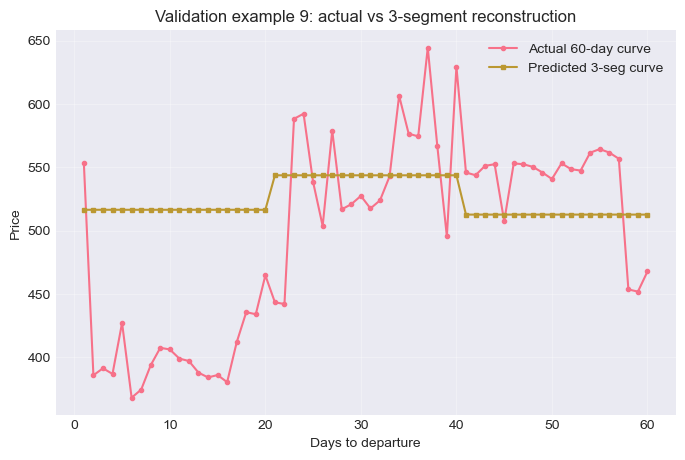

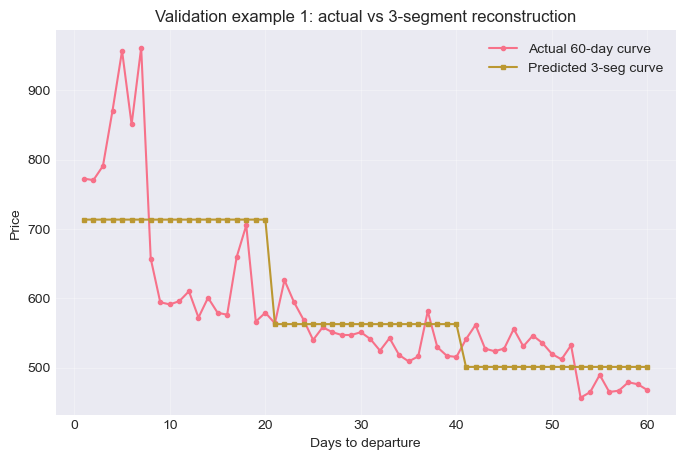

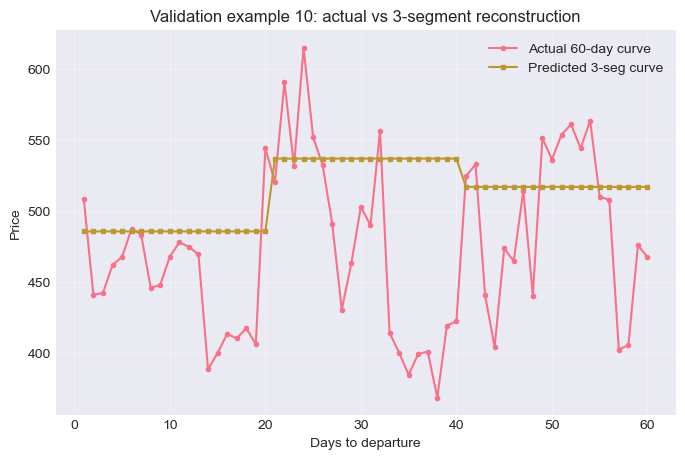


Average segment means over validation set:
  Early window (60-41 days): 489.69
  Mid window   (40-21 days): 541.49
  Late window  (20-1 days):  579.40

Approximate dip/peak regions (using 3-segment means):
  Lowest average prices in: early (60-41)
  Highest average prices in: late (20-1)


In [ ]:

# Alternative approach: 3-segment piecewise price profile

import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Build 3-segment targets (early, mid, late) from 60-day prices -> goal is to show general curvature
# y_train, y_val assumed shape: (n_samples, 60) with horizons 1..60 days

# this defines segment boundaries in terms of "days to departure"
# segment 1: days 60-41, segment 2: days 40-21, segment 3: days 20-1
horizons = np.arange(1, y_train.shape[1] + 1) 

seg1_mask = (horizons >= 41) & (horizons <= 60)
seg2_mask = (horizons >= 21) & (horizons <= 40)
seg3_mask = (horizons >= 1) & (horizons <= 20)


def segment_means(y, mask):
    # mean over columns in this mask, per row
    return np.nanmean(y[:, mask], axis=1, keepdims=True)


y_train_seg1 = segment_means(y_train, seg1_mask)  # shape (n_samples, 1)
y_train_seg2 = segment_means(y_train, seg2_mask)
y_train_seg3 = segment_means(y_train, seg3_mask)

y_val_seg1 = segment_means(y_val, seg1_mask)
y_val_seg2 = segment_means(y_val, seg2_mask)
y_val_seg3 = segment_means(y_val, seg3_mask)

y_train_seg = np.hstack([y_train_seg1, y_train_seg2, y_train_seg3])
y_val_seg = np.hstack([y_val_seg1, y_val_seg2, y_val_seg3])

print("Segmented target shapes (train/val):", y_train_seg.shape, y_val_seg.shape)

# Train multi-output XGBoost on segment means
seg_base_model = XGBRegressor(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=80,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=2.0,
    reg_alpha=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

seg_model = MultiOutputRegressor(seg_base_model)
print("Training 3-segment model...")
seg_model.fit(X_train, y_train_seg)
print("Training completed!")

# predictions in segment space
y_train_seg_pred = seg_model.predict(X_train)
y_val_seg_pred = seg_model.predict(X_val)


# remake 60-day curves from predicted segments 
def reconstruct_from_segments(seg_pred, n_outputs):
    """
    seg_pred: (n_samples, 3) with [m1, m2, m3]
    returns reconstructed curves of shape (n_samples, n_outputs)
    """
    n_samples = seg_pred.shape[0]
    recon = np.zeros((n_samples, n_outputs))

    m1 = seg_pred[:, 0][:, None]
    m2 = seg_pred[:, 1][:, None]
    m3 = seg_pred[:, 2][:, None]

    recon[:, seg1_mask] = m1
    recon[:, seg2_mask] = m2
    recon[:, seg3_mask] = m3
    return recon


y_train_recon = reconstruct_from_segments(y_train_seg_pred, y_train.shape[1])
y_val_recon = reconstruct_from_segments(y_val_seg_pred, y_val.shape[1])

# computes MAE
train_mae_seg = mean_absolute_error(y_train, y_train_recon)
val_mae_seg = mean_absolute_error(y_val, y_val_recon)

print(f"3-segment model Train MAE (price space): {train_mae_seg:.2f}")
print(f"3-segment model Validation MAE (price space): {val_mae_seg:.2f}")

# plots
rng = np.random.default_rng(42)  # for reproducibility
example_indices = rng.choice(y_val.shape[0], size=min(3, y_val.shape[0]), replace=False)

days = np.arange(1, y_val.shape[1] + 1)

for idx in example_indices:
    plt.figure(figsize=(8, 5))
    plt.plot(days, y_val[idx], label="Actual 60-day curve", marker="o", ms=3)
    plt.plot(days, y_val_recon[idx], label="Predicted 3-seg curve", marker="s", ms=3)

    plt.xlabel("Days to departure")
    plt.ylabel("Price")
    plt.title(f"Validation example {idx}: actual vs 3-segment reconstruction")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


# results summary to make sense of it all

# average segment means over all validation examples
avg_seg_means = y_val_seg.mean(axis=0)  # [m1, m2, m3]
m1, m2, m3 = avg_seg_means

print("\nAverage segment means over validation set:")
print(f"  Early window (60-41 days): {m1:.2f}")
print(f"  Mid window   (40-21 days): {m2:.2f}")
print(f"  Late window  (20-1 days):  {m3:.2f}")

# interpretation of dip/peak
segments = ["early (60-41)", "mid (40-21)", "late (20-1)"]
vals = [m1, m2, m3]
min_idx = int(np.argmin(vals))
max_idx = int(np.argmax(vals))

print("\nApproximate dip/peak regions (using 3-segment means):")
print(f"  Lowest average prices in: {segments[min_idx]}")
print(f"  Highest average prices in: {segments[max_idx]}")


Training Ridge multi-output model...
Training completed!
Predictions completed!

================ Ridge Regression Summary ================
Ridge Train MAE: 68.45
Ridge Validation MAE: 67.10

Per-output MAE (Ridge): mean=67.10, min=20.15, max=195.59


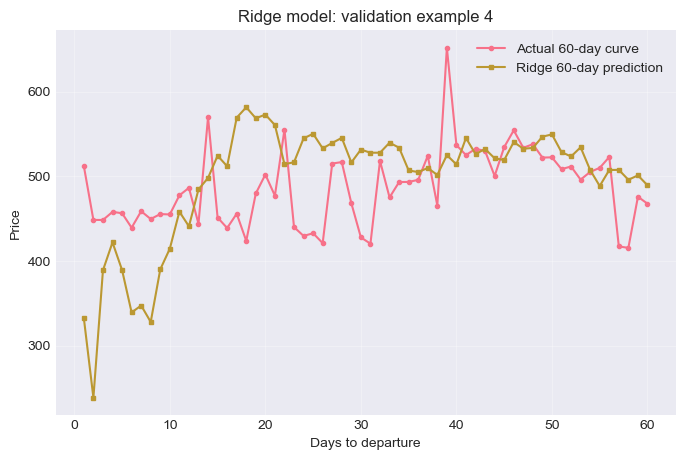

In [22]:
#using ridge regression instead of xgboost -> simpler approach

from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

# Define and train Ridge multi-output model
ridge_base = Ridge(alpha=1.0, random_state=42)  # L2-regularized linear model
ridge_model = MultiOutputRegressor(ridge_base)

print("Training Ridge multi-output model...")
ridge_model.fit(X_train, y_train)
print("Training completed!")

# Predictions on train and validation
y_train_pred_ridge = ridge_model.predict(X_train)
y_val_pred_ridge = ridge_model.predict(X_val)
print("Predictions completed!")

# Compute MAE in original 60-day price space
ridge_train_mae = mean_absolute_error(y_train, y_train_pred_ridge)
ridge_val_mae = mean_absolute_error(y_val, y_val_pred_ridge)

print("\n================ Ridge Regression Summary ================")
print(f"Ridge Train MAE: {ridge_train_mae:.2f}")
print(f"Ridge Validation MAE: {ridge_val_mae:.2f}")

# 4. Per-horizon MAE
n_samples, n_outputs = y_val.shape
ridge_mae_per_output = [
    mean_absolute_error(y_val[:, i], y_val_pred_ridge[:, i]) for i in range(n_outputs)
]

print(
    f"\nPer-output MAE (Ridge): "
    f"mean={np.mean(ridge_mae_per_output):.2f}, "
    f"min={np.min(ridge_mae_per_output):.2f}, "
    f"max={np.max(ridge_mae_per_output):.2f}"
)

# compare one validation curve visually
example_idx = 4  # pick any validation example
days = np.arange(1, y_val.shape[1] + 1)

plt.figure(figsize=(8, 5))
plt.plot(days, y_val[example_idx], label="Actual 60-day curve", marker="o", ms=3)
plt.plot(
    days,
    y_val_pred_ridge[example_idx],
    label="Ridge 60-day prediction",
    marker="s",
    ms=3,
)

plt.xlabel("Days to departure")
plt.ylabel("Price")
plt.title(f"Ridge model: validation example {example_idx}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [7]:
%pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


## Evaluate and Visualize Results
Calculate MAE metrics and create visualizations comparing predictions to ground truth across different days-to-departures.



PREDICTION COMPARISON SUMMARY

Validation Results:
Overall MAE: 61.11

Total predictions: 840
Number of samples: 14
Number of outputs per sample: 60

Comparison DataFrame (first 20 rows):
    sample_idx  days_to_departure      actual   predicted  absolute_error
0            0                  1  435.381250  425.112000       10.269250
1            0                  2  482.261290  436.747101       45.514189
2            0                  3  529.019355  423.009338      106.010016
3            0                  4  355.332143  478.216888      122.884746
4            0                  5  391.777419  510.130951      118.353532
..         ...                ...         ...         ...             ...
95           1                 36  516.318400  564.943298       48.624898
96           1                 37  581.525000  530.488281       51.036719
97           1                 38  529.680417  532.224487        2.544071
98           1                 39  517.160400  512.213196        4.9472

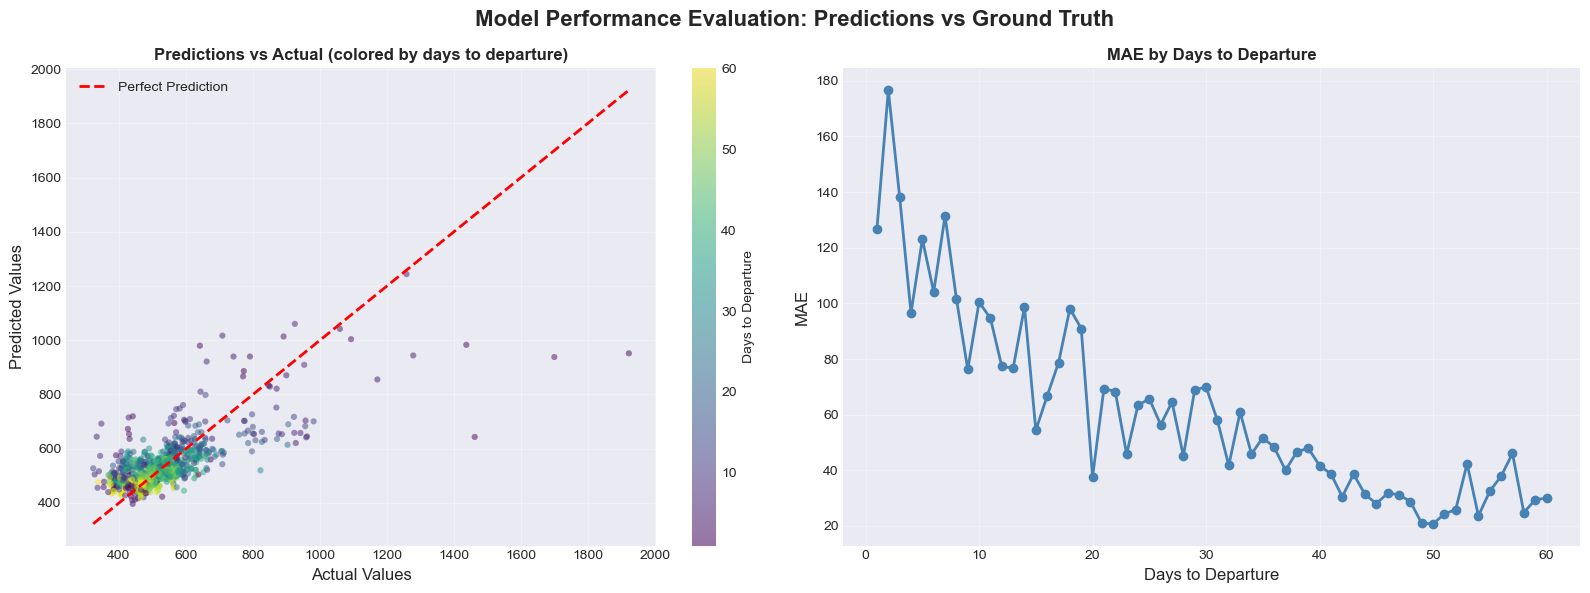

In [13]:
# ============================================================================
# Model Evaluation Visualizations
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Flatten predictions and actuals for comparison DataFrame
n_samples, n_outputs = y_val.shape
comparison_data = []

for sample_idx in range(n_samples):
    for output_idx in range(n_outputs):
        actual = y_val[sample_idx, output_idx]
        predicted = y_val_pred[sample_idx, output_idx]
        abs_error = abs(actual - predicted)
        pct_error = (abs_error / actual * 100) if actual != 0 else np.nan
        
        # Extract days to departure from column name
        days_to_departure = int(target_cols[output_idx].split()[0])
        
        comparison_data.append({
            'sample_idx': sample_idx,
            'days_to_departure': days_to_departure,
            'actual': actual,
            'predicted': predicted,
            'absolute_error': abs_error,
        })

comparison_df = pd.DataFrame(comparison_data)

# Display comparison DataFrame summary
print("\n" + "="*80)
print("PREDICTION COMPARISON SUMMARY")
print("="*80)

mae_per_output = [mean_absolute_error(y_val[:, i], y_val_pred[:, i]) for i in range(y_val.shape[1])]
overall_mae = mean_absolute_error(y_val, y_val_pred)

print(f"\nValidation Results:")
print(f"Overall MAE: {overall_mae:.2f}")

print(f"\nTotal predictions: {len(comparison_df)}")
print(f"Number of samples: {n_samples}")
print(f"Number of outputs per sample: {n_outputs}")
print(f"\nComparison DataFrame (first 20 rows):")
print(comparison_df.head(100))

# ============================================================================
# Visualizations: Predictions vs Actual and MAE by Days to Departure
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Evaluation: Predictions vs Ground Truth', fontsize=16, fontweight='bold')

# Plot 1: Scatter plot - Predictions vs Actual
ax1 = axes[0]
scatter = ax1.scatter(comparison_df['actual'], comparison_df['predicted'], 
                     alpha=0.5, s=20, c=comparison_df['days_to_departure'], 
                     cmap='viridis', edgecolors='none')
min_val = min(comparison_df['actual'].min(), comparison_df['predicted'].min())
max_val = max(comparison_df['actual'].max(), comparison_df['predicted'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Values', fontsize=12)
ax1.set_ylabel('Predicted Values', fontsize=12)
ax1.set_title('Predictions vs Actual (colored by days to departure)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Days to Departure')

# Plot 2: MAE by Days to Departure
ax2 = axes[1]
days_list = [int(col.split()[0]) for col in target_cols]
ax2.plot(days_list, mae_per_output, marker='o', linewidth=2, markersize=6, color='steelblue')
ax2.set_xlabel('Days to Departure', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('MAE by Days to Departure', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 61, 10))

plt.tight_layout()
plt.show()